<a href="https://colab.research.google.com/github/ejf78/cdc_vitalsigns/blob/master/Vital%20Signs%20Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Compile and Analyse Vital Signs


After a little bit of manual cleaning, I got the historic data (2000-2010) for many indicators into a common format, stored in several different excel files with several sheets each. I also saved the modern (2010 onward) indicators as CSVs, to avoid re-pulling from the APIs. In this notebook, I'll compile everything and set up some analysis. 

### Colab-Specific Steps

In [1]:
# clone the github respository, so that we have all the necessary files 
!git clone https://github.com/ejf78/cdc_vitalsigns.git

Cloning into 'cdc_vitalsigns'...
remote: Enumerating objects: 88, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 88 (delta 35), reused 52 (delta 13), pack-reused 0
Unpacking objects: 100% (88/88), done.
Checking out files: 100% (36/36), done.


In [2]:
# install geopandas in google colab 
!pip install geopandas

     |████████████████████████████████| 1.0 MB 7.0 MB/s 
     |████████████████████████████████| 6.3 MB 44.2 MB/s 
     |████████████████████████████████| 15.4 MB 32 kB/s 


In [3]:
# load packages
import pandas as pd
import os # for navigating directories
import requests
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
from matplotlib import animation 
import math # for ceil function (round up)

In [4]:
# navigate into the directory
os.chdir("cdc_vitalsigns")

## Load and Compile Data (pre-processing)


In [5]:
# api info 
# read list of indicators 
api_df = pd.read_csv("VS-Indicator-APIs_EF.csv") # new version - I've labeled which API calls to make under 'pull'
api_df.set_index("ShortName", inplace=True, drop = False) # drop = False I want ShortName as a column 
# add a column for indicator shortname, without the XX's, and lowercase for uniformity 
api_df["shortname_noX"] = api_df.ShortName.str.replace("XX","").str.lower()
api_df

,Indicator Number,Indicator,ShortName,Section,API,pull,shortname_noX
ShortName,,,,,,,
tpopXX,1,Total Population,tpopXX,Census Demographics,https://services1.arcgis.com/mVFRs7NF4iFitgbY/...,1,tpop
maleXX,2,Total Male Population,maleXX,Census Demographics,https://services1.arcgis.com/mVFRs7NF4iFitgbY/...,1,male
femaleXX,3,Total Female Population,femaleXX,Census Demographics,https://services1.arcgis.com/mVFRs7NF4iFitgbY/...,1,female
paaXX,4,Percent of Residents - Black/African-American ...,paaXX,Census Demographics,https://services1.arcgis.com/mVFRs7NF4iFitgbY/...,1,paa
pwhiteXX,5,Percent of Residents - White/Caucasian (Non-Hi...,pwhiteXX,Census Demographics,https://services1.arcgis.com/mVFRs7NF4iFitgbY/...,1,pwhite
...,...,...,...,...,...,...,...
pread8XX,211,Percentage of 8th Grade Students who Met or Ex...,pread8XX,Education and Youth,https://services1.arcgis.com/mVFRs7NF4iFitgbY/...,1,pread8
palg1XX,212,Percentage of Students who Met or Exceeded PAR...,palg1XX,Education and Youth,https://services1.arcgis.com/mVFRs7NF4iFitgbY/...,1,palg1
palg2XX,213,Percentage of Students who Met or Exceeded PAR...,palg2XX,Education and Youth,https://services1.arcgis.com/mVFRs7NF4iFitgbY/...,1,palg2


#### Historic Data (2000 - 2006) 

Already cleaned 

In [6]:
### historic data 
# read from CSV 
historic_indicators = pd.read_csv("precompiled_historic_indicators.csv")
# pivot longer for join 
hvs = historic_indicators.melt(id_vars = ["CSA", "indicator", "indicator_category"], 
                        var_name = "year")
# drop indicator category (will add it later so that it's uniform)
hvs = hvs.drop(["indicator_category"], axis = 1)
# remove the XX's from the indicator names 
hvs["indicator"] = hvs.indicator.str.replace("XX","")

#### Clean data from 2010 onward

In [ ]:
### modern data 
# read in data files for modern indicators (saved from previous API kills)
mvs1 = pd.read_csv("modern_vital_signs_raw_1.csv")
mvs2 = pd.read_csv("modern_vital_signs_raw_2.csv")
mvs3 = pd.read_csv("modern_vital_signs_raw_3.csv")



## reformat / melt 
# msv1 
objectid_cols = [col for col in mvs1.columns if "OBJECTID" in col] # remove any columns called OBJECTID
mvs1 = mvs1.drop(objectid_cols, axis = 1) 
# drop geometry as well; it's causing some problems
mvs1 = mvs1.drop(['Shape__Area', 'Shape__Length', "geometry"], axis = 1)
index_cols = ["CSA2010"]
mvs_df_1 = mvs1.melt(id_vars = index_cols,
                     var_name = "year-indicator",
                     value_name = "value")
# msv2 
objectid_cols = [col for col in mvs2.columns if "OBJECTID" in col]
mvs2 = mvs2.drop(objectid_cols, axis = 1)
mvs2 = mvs2.drop(['Shape__Area', 'Shape__Length', "geometry"], axis = 1)
mvs_df_2 = mvs2.melt(id_vars = index_cols,
                     var_name = "year-indicator",
                     value_name = "value")
# msv3
objectid_cols = [col for col in mvs3.columns if "OBJECTID" in col]
mvs3 = mvs3.drop(objectid_cols, axis = 1)
mvs3 = mvs3.drop(['Shape__Area', 'Shape__Length', "geometry","CSA2010_1"], axis = 1)  # one off issue: drop "CSA2010_1" column
mvs_df_3 = mvs3.melt(id_vars = index_cols,
                     var_name = "year-indicator",
                     value_name = "value")

# rename
mvs_df_1 = mvs_df_1.rename(columns = {"CSA2010":"CSA"})
mvs_df_2 = mvs_df_2.rename(columns = {"CSA2010":"CSA"})
mvs_df_3 = mvs_df_3.rename(columns = {"CSA2010":"CSA"})
## add column for year, based on indicator/year field 
mvs_df_1["year"] = ['20' + i[-2:] for i in mvs_df_1["year-indicator"]]
mvs_df_2["year"] = ['20' + i[-2:] for i in mvs_df_2["year-indicator"]]
mvs_df_3["year"] = ['20' + i[-2:] for i in mvs_df_3["year-indicator"]]
## add column for indicator, based on indicator/year field 
mvs_df_1["indicator"] = [i[:-2] for i in mvs_df_1["year-indicator"]]
mvs_df_2["indicator"] = [i[:-2] for i in mvs_df_2["year-indicator"]]
mvs_df_3["indicator"] = [i[:-2] for i in mvs_df_3["year-indicator"]]
# drop year-indicator field 
mvs_df_1 = mvs_df_1.drop(["year-indicator"], axis = 1)
mvs_df_2 = mvs_df_2.drop(["year-indicator"], axis = 1)
mvs_df_3 = mvs_df_3.drop(["year-indicator"], axis = 1)
# ended up with duplicates because of NA values. Drop those 
mvs_df_1.dropna(subset = ["value"], inplace = True)
mvs_df_2.dropna(subset = ["value"], inplace = True)
mvs_df_3.dropna(subset = ["value"], inplace = True)
# it also seems like there are some indicators where the API failed to pull data, resulting in NAs in CSA2010 
mvs_df_1.dropna(subset = ["CSA"], inplace = True)
mvs_df_2.dropna(subset = ["CSA"], inplace = True)
mvs_df_3.dropna(subset = ["CSA"], inplace = True)



/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (371) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# UNUSED 
##### pivot again, so that columns are years (not currently in use)
index_cols_pivotlonger = ["CSA", "indicator"]
mvs_pivot_1 = mvs_df_1.pivot(index = index_cols_pivotlonger,columns = "year", values = "value").reset_index()
mvs_pivot_2 = mvs_df_2.pivot(index = index_cols_pivotlonger,columns = "year", values = "value").reset_index()
mvs_pivot_3 = mvs_df_3.pivot(index = index_cols_pivotlonger,columns = "year", values = "value").reset_index()

### small data fix - remove some placeholder rows from mvs3 
mvs_df_3 = mvs_df_3.query("indicator != 'CSA2010'")
# export, for posterity
mvs_pivot_1.to_csv("modern_vital_signs_pivot_1.csv", index = False)
mvs_pivot_2.to_csv("modern_vital_signs_pivot_2.csv", index = False)
mvs_pivot_3.to_csv("modern_vital_signs_pivot_3.csv", index = False)

#### Compile into one dataframe

In [ ]:
### concatenate into one big dataframe of vital signs 
vs = pd.concat([hvs, mvs_df_1,mvs_df_2,mvs_df_3])

In [ ]:
### clean some names 
# remove asterisk from CSA names
# correct some spellings 
# unify some names that may be abbreviated
vs["CSA"] = vs.CSA.str.replace("*","", regex = False)
vs["CSA"] = vs.CSA.str.replace("Edmonson","Edmondson", regex = False)
vs["CSA"] = vs.CSA.str.replace("Falstaff","Fallstaff", regex = False) # really not sure which is right, but BNIA uses Fallstaff in modern communications
vs["CSA"] = vs.CSA.str.replace("Mt. Washington","Mount Washington", regex = False)
vs["CSA"] = vs.CSA.str.replace("Mt. Winans","Mount Winans", regex = False)
# make indicator lowercase (for uniformity)
vs["indicator"] = vs.indicator.str.lower()

Things that need to get cleaned up: 
- anything with a * 
- Edmonson Village vs Edmondson Village
- Glen-Fallstaff vs. Glen-Falstaff
- 'Mount Washington/Coldspring','Mt. Washington/Coldspring'
- Westport/Mount Winans/Lakeland vs Westport/Mt. Winans/Lakeland

Changes in CSA names / boundaries: 
- Perkins/Middle East vs Oldtown/Middle East
- Jonestown/Oldtown vs. Oldtown / Middle East
- Washington Village vs. Washington Village/Pigtown
- 'Medfield/Hampden/Woodberry', vs 'Medfield/Hampden/Woodberry/Remington'

In [ ]:
### one-off issue: hhsize API returns a dataframe that does not include year, so we need to do some correcting 
# update 1/28/2022: Cheryl @ BNIA confirmed the year is 2010. This should be corrected in future API pulls.
# rename the indicator
vs["indicator"]  = vs.indicator.replace("hhsi","hhsize")
# replace the year value with unknown 
vs["year"] = vs.year.replace("20ze","2010")

In [ ]:
# add a numeric year field 
  # ('2006 - 2010' will be NA, which is okay, because this time frame isn't a perfect comparison to other years)
vs["year_numeric"] = pd.to_numeric(vs.year, errors = "coerce", downcast = "integer")
# make 'value' numeric
vs["value"] = pd.to_numeric(vs.value, errors = "coerce")


In [ ]:
# get some info about the final table of vital signs 
vs.describe(include = "all")
vs.isna().sum() # how many NA's per column? 

CSA                 0
indicator           0
year                0
value           43833
year_numeric     5916
dtype: int64

In [ ]:
# remove rows where value is NA
vs.dropna(subset = ["value"], inplace = True)
# sometimes we have multiple values for 2010 indicators (from historic and from API)
  # round to 4 digits (for uniformity) & remove duplicates 
vs["value"] = vs.value.round(4)
vs = vs.drop_duplicates()

In [ ]:
vs.head(10)

,CSA,indicator,year,value,year_numeric
0,Allendale/Irvington/S. Hilton,female,2000,10640.0,2000.0
1,Beechfield/Ten Hills/West Hills,female,2000,7110.0,2000.0
2,Belair-Edison,female,2000,9516.0,2000.0
3,Brooklyn/Curtis Bay/Hawkins Point,female,2000,6972.0,2000.0
4,Canton,female,2000,3546.0,2000.0
5,Cedonia/Frankford,female,2000,12404.0,2000.0
6,Cherry Hill,female,2000,4485.0,2000.0
7,Chinquapin Park/Belvedere,female,2000,4551.0,2000.0
8,Claremont/Armistead,female,2000,4612.0,2000.0
9,Clifton-Berea,female,2000,6804.0,2000.0


In [ ]:
# export for posterity 
vs.to_csv("full_vital_signs.csv", index = False)

In [ ]:
### create an info dataframe of indicator, years available, description, and category 
# function for a sorted set 
def sort_set(series):
  x = set(series)
  return sorted(x)

# get dataframe of indicators and years available for each (sorted)
info = vs[["indicator","year"]].groupby(["indicator"])["year"].apply(sort_set).reset_index()
# grab the info from the api DF
indicator_desc = api_df.rename(columns = {"Indicator":"indicator_description","shortname_noX":"indicator","Section":"category"})[["indicator_description","indicator","category"]]
info = info.merge(indicator_desc, how = "left")
# add column for number of years available 
info["count_years_available"] = [len(yrs) for yrs in info.year]
info

,indicator,year,indicator_description,category,count_years_available
0,aastud,"[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201...",Percent of Students that are African American ...,Education and Youth,15
1,abse,"[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201...",Percent of 1st-5th Grade Students that are Chr...,Education and Youth,14
2,abshs,"[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201...",Percent of 9th-12th Grade Students that are Ch...,Education and Youth,14
3,absmd,"[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201...",Percent of 6th-8th Grade Students that are Chr...,Education and Youth,14
4,affordm,"[2000, 2006 - 2010, 2010, 2011, 2012, 2013, 20...",Affordability Index - Mortgage,Housing and Community Development,12
...,...,...,...,...,...
159,viol,"[2000, 2001, 2002, 2003, 2004, 2005, 2006, 200...","Violent Crime Rate per 1,000 Residents",Crime and Safety,21
160,voted,"[2010, 2012, 2014, 2016, 2018]",Percent Population (Over the age of 18) Who Vo...,Sustainability,5
161,walked,"[2011, 2012, 2013, 2014, 2015, 2016, 2017, 201...",Percent of Population that Walks to Work,Sustainability,9
162,wlksc,"[2011, 2017]",Walk Score,Sustainability,2


In [ ]:
# export 
info.to_csv("indicator_info.csv", index = False)

In [ ]:
# how many unique indicators did I end up with? 
len(set(vs.indicator)) # great

164

In [ ]:
# check out a list the indicators
indicator_list = list(set(vs.indicator))
indicator_list.sort()
indicator_list

['aastud',
 'abse',
 'abshs',
 'absmd',
 'affordm',
 'affordr',
 'age0-18_',
 'age18_',
 'age24_',
 'age45-64_',
 'age5_',
 'age64_',
 'age65_',
 'arrest',
 'artevnt',
 'bahigher',
 'baltvac',
 'banks',
 'birthwt',
 'biz1_',
 'biz2_',
 'biz4_',
 'bkln',
 'business_50-99_emp',
 'busload',
 'caracc',
 'caslt',
 'clogged',
 'cmos',
 'community_dev_corporations',
 'community_gardens',
 'comp',
 'compl',
 'comprop',
 'constper',
 'crehab',
 'crime',
 'dirtyst',
 'dom',
 'domvio',
 'drop',
 'eattend',
 'ebll',
 'elheat',
 'empl',
 'fam',
 'familiesrelatedkids',
 'farms',
 'fastfd',
 'female',
 'femhhs',
 'fore',
 'gunhom',
 'hazardous_waste_sites_count',
 'hcvhouse',
 'heatgas',
 'hfai',
 'hh25inc',
 'hh40inc',
 'hh60inc',
 'hh75inc',
 'hhchpov',
 'hhm75',
 'hhpov',
 'hhs',
 'hhsize',
 'historical_buildings',
 'hs_degree_only_25plus',
 'hsaalg',
 'hsabio',
 'hsaeng',
 'hsagov',
 'hsattend',
 'hsdipl',
 'hstud',
 'individuals_below_povline',
 'juvarr',
 'juvdrug',
 'juvviol',
 'kra',
 'leadte

In [ ]:
# side note - get list of CSAs to check for duplicates (include which years are listed with which name)
csa_by_year = vs[["CSA","year"]].groupby(["CSA"])["year"].apply(sort_set).reset_index()
# write to csv to examine in Excel 
csa_by_year.to_csv("csa_names.csv", index = False)

## Load Pre-Processed Data

In [7]:
# vital signs 
vs = pd.read_csv("full_vital_signs.csv")
# make value numeric (float), make year integer 
vs.value = pd.to_numeric(vs.value, errors = "coerce")
vs.head()

,CSA,indicator,year,value,year_numeric
0,Allendale/Irvington/S. Hilton,female,2000,10640.0,2000.0
1,Beechfield/Ten Hills/West Hills,female,2000,7110.0,2000.0
2,Belair-Edison,female,2000,9516.0,2000.0
3,Brooklyn/Curtis Bay/Hawkins Point,female,2000,6972.0,2000.0
4,Canton,female,2000,3546.0,2000.0


In [8]:
vs.describe()

,value,year_numeric
count,77280.000000,76160.000000
mean,2435.823947,2011.908600
std,19210.571354,5.241012
min,0.000000,2000.000000
25%,7.079900,2009.000000
50%,28.370400,2012.000000
75%,71.900050,2016.000000
max,651154.000000,2020.000000


In [9]:
# api info 
api_df = pd.read_csv("VS-Indicator-APIs_EF.csv")
# set index to shortname, drop = False (still want a shortname column)
api_df.set_index("ShortName", inplace=True, drop = False) 
api_df.head()

,Indicator Number,Indicator,ShortName,Section,API,pull
ShortName,,,,,,
tpopXX,1,Total Population,tpopXX,Census Demographics,https://services1.arcgis.com/mVFRs7NF4iFitgbY/...,1
maleXX,2,Total Male Population,maleXX,Census Demographics,https://services1.arcgis.com/mVFRs7NF4iFitgbY/...,1
femaleXX,3,Total Female Population,femaleXX,Census Demographics,https://services1.arcgis.com/mVFRs7NF4iFitgbY/...,1
paaXX,4,Percent of Residents - Black/African-American ...,paaXX,Census Demographics,https://services1.arcgis.com/mVFRs7NF4iFitgbY/...,1
pwhiteXX,5,Percent of Residents - White/Caucasian (Non-Hi...,pwhiteXX,Census Demographics,https://services1.arcgis.com/mVFRs7NF4iFitgbY/...,1


In [10]:
# load indicator info 
info = pd.read_csv("indicator_info.csv")
info.head()

,indicator,year,indicator_description,category,count_years_available
0,aastud,"['2000', '2001', '2002', '2003', '2004', '2005...",Percent of Students that are African American ...,Education and Youth,21
1,abse,"['2000', '2001', '2002', '2003', '2004', '2005...",Percent of 1st-5th Grade Students that are Chr...,Education and Youth,20
2,abshs,"['2000', '2001', '2002', '2003', '2004', '2005...",Percent of 9th-12th Grade Students that are Ch...,Education and Youth,20
3,absmd,"['2000', '2001', '2002', '2003', '2004', '2005...",Percent of 6th-8th Grade Students that are Chr...,Education and Youth,20
4,affordm,"['2000', '2001', '2002', '2003', '2004', '2005...",Affordability Index - Mortgage,Housing and Community Development,21


### Grabbing Geometry

In [11]:
### pull a geodataframe using Colin's functions 

# functions
def getGDFfromURL(url, layer=0):
    #GDF stands for GeoDataFrame; this is the innermost function called by getGDF
    tail = "/"+str(layer)+"/query?where=1%3D1&outFields=*&outSR=4326&f=json" #worked this out
    url+=tail
    print(url)
    gdf = gpd.read_file(url) #GeoPandas has a built in function to read APIs given right URL
    return gdf

def getGDF(shortname, level=0):
    #This is outermost function called by user; it calls getGDFfromURL
    url = api_df.loc[shortname, "API"]
    return getGDFfromURL(url, level)

# using HH size as our sample GDF (since I had questions about this indicator anyway)
hhsizeXX = getGDF("hhsizeXX")
hhsizeXX.head(10) # note - looks like BNIA has corrected the issue with hhsize 

https://services1.arcgis.com/mVFRs7NF4iFitgbY/arcgis/rest/services/Hhsize/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json


,OBJECTID,CSA2010,hhsize10,Shape__Area,Shape__Length,geometry
0,1,Allendale/Irvington/S. Hilton,2.64,6.377046e+07,38770.165571,"POLYGON ((-76.65726 39.27600, -76.65726 39.276..."
1,2,Beechfield/Ten Hills/West Hills,2.4,4.788253e+07,37524.950533,"POLYGON ((-76.69479 39.30201, -76.69465 39.301..."
2,3,Belair-Edison,2.9,4.495003e+07,31307.314843,"POLYGON ((-76.56761 39.32636, -76.56746 39.326..."
3,4,Brooklyn/Curtis Bay/Hawkins Point,2.61,1.760777e+08,150987.703639,"MULTIPOLYGON (((-76.58867 39.21283, -76.58824 ..."
4,5,Canton,1.86,1.540854e+07,23338.611948,"POLYGON ((-76.57140 39.28441, -76.57138 39.284..."
5,6,Cedonia/Frankford,2.54,7.154134e+07,39962.549835,"POLYGON ((-76.52972 39.33113, -76.53005 39.331..."
6,7,Cherry Hill,2.57,2.914418e+07,22305.302067,"POLYGON ((-76.61525 39.24102, -76.61530 39.241..."
7,8,Chinquapin Park/Belvedere,2.26,2.102259e+07,21705.411630,"POLYGON ((-76.59491 39.35406, -76.59507 39.354..."
8,9,Claremont/Armistead,2.41,6.124377e+07,40104.415980,"POLYGON ((-76.52975 39.31020, -76.52990 39.310..."
9,10,Clifton-Berea,2.83,2.328523e+07,24022.764621,"POLYGON ((-76.58449 39.31491, -76.58249 39.314..."


In [12]:
### get a dataframe of neighborhoods and geometries 
# select and copy relevant columns 
geos = hhsizeXX[['CSA2010','Shape__Area', 'Shape__Length','geometry']].copy()

# correct CSA names to align with vs dataframe
geos = geos.rename(columns = {"CSA2010":"CSA"})
geos["CSA"] = geos.CSA.str.replace("*","", regex = False)
geos["CSA"] = geos.CSA.str.replace("Edmonson","Edmondson", regex = False)
geos["CSA"] = geos.CSA.str.replace("Falstaff","Fallstaff", regex = False) # really not sure which is right, but BNIA uses Fallstaff in modern communications
geos["CSA"] = geos.CSA.str.replace("Mt. Washington","Mount Washington", regex = False)
geos["CSA"] = geos.CSA.str.replace("Mt. Winans","Mount Winans", regex = False)
geos.head()

,CSA,Shape__Area,Shape__Length,geometry
0,Allendale/Irvington/S. Hilton,6.377046e+07,38770.165571,"POLYGON ((-76.65726 39.27600, -76.65726 39.276..."
1,Beechfield/Ten Hills/West Hills,4.788253e+07,37524.950533,"POLYGON ((-76.69479 39.30201, -76.69465 39.301..."
2,Belair-Edison,4.495003e+07,31307.314843,"POLYGON ((-76.56761 39.32636, -76.56746 39.326..."
3,Brooklyn/Curtis Bay/Hawkins Point,1.760777e+08,150987.703639,"MULTIPOLYGON (((-76.58867 39.21283, -76.58824 ..."
4,Canton,1.540854e+07,23338.611948,"POLYGON ((-76.57140 39.28441, -76.57138 39.284..."


In [13]:
# add geometry to vital sign data
vsg = vs.merge(geos, how = "left")
# add indicator description, where available 
vsg = vsg.merge(info[["indicator", "indicator_description"]], how = "left")
# turn into a geodataframe
vsg = gpd.GeoDataFrame(vsg)
vsg.head()

,CSA,indicator,year,value,year_numeric,Shape__Area,Shape__Length,geometry,indicator_description
0,Allendale/Irvington/S. Hilton,female,2000,10640.0,2000.0,6.377046e+07,38770.165571,"POLYGON ((-76.65726 39.27600, -76.65726 39.276...",Total Female Population
1,Beechfield/Ten Hills/West Hills,female,2000,7110.0,2000.0,4.788253e+07,37524.950533,"POLYGON ((-76.69479 39.30201, -76.69465 39.301...",Total Female Population
2,Belair-Edison,female,2000,9516.0,2000.0,4.495003e+07,31307.314843,"POLYGON ((-76.56761 39.32636, -76.56746 39.326...",Total Female Population
3,Brooklyn/Curtis Bay/Hawkins Point,female,2000,6972.0,2000.0,1.760777e+08,150987.703639,"MULTIPOLYGON (((-76.58867 39.21283, -76.58824 ...",Total Female Population
4,Canton,female,2000,3546.0,2000.0,1.540854e+07,23338.611948,"POLYGON ((-76.57140 39.28441, -76.57138 39.284...",Total Female Population


## Visualize

### Playing around

In [ ]:
## copying over Colin's function for a simple geopandas plot 
# UNUSED 
def plotStd(shortname, year=19, figsize=(5,5), legend=True, cmap="Greys"):
    #Will generate a choropleth using built in GeoPandas plotting 
    #Get the GDF and then chose the column to plot
    gdf = getGDF(shortname)
    targetCol = shortname[:-2]+str(year)
    gdf.plot(targetCol,figsize=figsize, legend=legend, cmap=cmap)

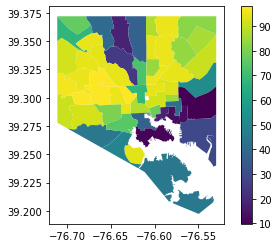

In [ ]:
# one indicator in one year 
z = vsg[(vsg.indicator == "aastud") & (vsg.year == "2020")]
z.plot("value", legend = True)

In [ ]:
vsg.CSA[0]

'Allendale/Irvington/S. Hilton'

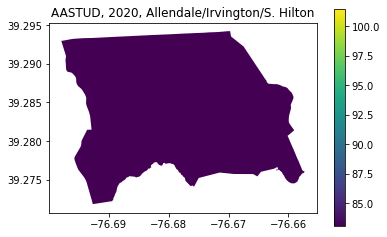

In [ ]:
# what would this look like for a single CSA? 
ax = vsg[(vsg.indicator == "aastud") & (vsg.year == "2020")].head(1) # first CSA 
ax.plot("value", legend = True)

plt.title(f"AASTUD, 2020, {vsg.CSA[0]}")
plt.show()

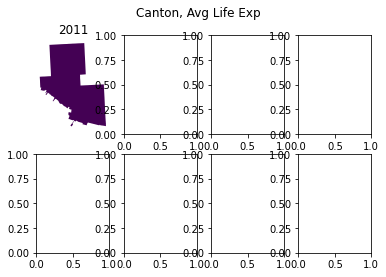

In [ ]:
# let's look at a single CSA, for a single indicator and several static plots over the years 

## (MANUAL TEST)

# choosing a stable CSA, looking at life expectancy 
canton_lifexp = vsg[(vsg.CSA == "Canton") & (vsg.indicator == "lifexp")]
canton_lifexp.shape # 8 years of data 

## plot 
# subplots with 2 rows, 4 columns 
fig, ax = plt.subplots(2, 4)
# set up one plot 
df1 = canton_lifexp[canton_lifexp.year == "2011"]
df1.plot("value", ax = ax[0,0])

ax[0,0].set_axis_off()
ax[0,0].set_title("2011")

fig.suptitle("Canton, Avg Life Exp")
fig.show()

#ax[0,0] = canton_lifexp.plot("value")

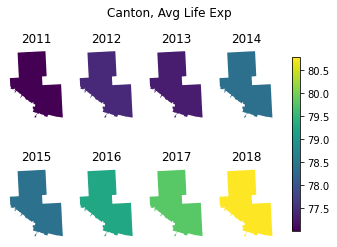

In [ ]:
## programmatically populate the graphs

# choosing a stable CSA, looking at life expectancy 
canton_lifexp = vsg[(vsg.CSA == "Canton") & (vsg.indicator == "lifexp")]
# get a list of years 
yrs = [y for y in canton_lifexp.year]

# set up the figure 
fig, ax = plt.subplots(2, 4, sharex = True, sharey = True)
fig.suptitle("Canton, Avg Life Exp")
# set up min and max values to anchor the choropleth, so legend is consistent
anchor_min = canton_lifexp.value.min()
anchor_max = canton_lifexp.value.max()


# loop through each year to create plot
c = 0  # set first column index
for y in yrs:
  # what row, first or second? 
  if yrs.index(y) <= 3:
    r = 0
  else: 
    r = 1
  # change col index, if we've moved to the second row 
  if yrs.index(y) == 4:
    c -= 4
  # grab that year's data 
  mapdat = canton_lifexp[canton_lifexp.year == y]
  # plot 
  mapdat.plot("value", ax = ax[r, c], vmin = anchor_min, vmax = anchor_max)
  ax[r,c].set_axis_off()
  ax[r,c].set_title(y)
  # move to the next column 
  c += 1 

patch_col = ax[0,0].collections[0]
fig.colorbar(patch_col, ax = ax, shrink = 0.8)
# fig.colorbar(patch_col, ax = ax, shrink = 0.8, orientation = "horizontal") # could change the legend orientation
fig.show()

### Function 1: Subset a dataframe
 

In [14]:
### function to subset a dataframe 
# written with vital signs in mind, but flexible to use for other datasets 
def subset_dataframe(dataframe, columns, subset_vals,
                     condition_parameters = [" == "]): 
  '''
  Returns a subsetted dataframe
  *** 
  dataframe: a dataframe object (pandas or geopandas)
  columns: a list of columns (as strings) by which you'd like to subset the data 
  subset_val: a list of values by which to subset the data. The order must correspond to the order of the columns. 
  condition_parameters: a list of strings indicating the query relationship. MUST BE A LIST, even if it only contains one value. 
    Default will look for an exact match (==) for each column/subset value
    You may provide a list of parameters equal to the number of columns by which you're subsetting, 
    or you can provide a single parameter to apply to each column. 
    If using greater than or less than, the corresponding value must be numeric (both in the dataset and in the subset_vals list)
    example 1: condition_parameters = ["==",">", "=="] will query for an exact match for the first and third columns provided, and a greater than match for the second column. 
    example 2: condition_parameters = [">="] will query for a 'greater-than or equal to' match for every column

  The list of columns and the list of subset values must be the same length 

  The function works by constructing a string of filter conditions, and feeding it into panda's query function
  '''
  # create a list of condition parameters, if a single parameter (or no parameter) is provided
    # default is ' == '
  if len(condition_parameters) == 1: 
    condition_parameters = condition_parameters * len(columns)
  # empty string to hold the conditions
  condition = ''
  # loop to add conditions
  for i in range(0,len(columns)):
    if type(subset_vals[i]) == int or type(subset_vals[i])  == float:
      subset_val_string = str(subset_vals[i])
    elif type(subset_vals[i]) == list:   # if provided a list of exact values to filter for (such as multiple CSAs)
      subset_val_string = str(subset_vals[i])
    else: 
      subset_val_string = "'" + subset_vals[i] + "'" # add single quotes if it's not a numeric variable 
    condition = condition + " & " + columns[i] + condition_parameters[i] + subset_val_string
  # remove the first 3 characters in the condition (space & space)
  condition = condition[3:]
  #return condition # use this line for testing
  return vsg.query(condition)



##### testing the subset function

In [15]:
# test a few conditions
subset_dataframe(vsg, ["CSA","indicator","year"], ["Belair-Edison", "female", "2000"])

,CSA,indicator,year,value,year_numeric,Shape__Area,Shape__Length,geometry,indicator_description
2,Belair-Edison,female,2000,9516.0,2000.0,4.495003e+07,31307.314843,"POLYGON ((-76.56761 39.32636, -76.56746 39.326...",Total Female Population


In [16]:
# test how it does with numeric data 
subset_dataframe(vsg, ["CSA","indicator","year_numeric"], ["Belair-Edison", "female", 2000])

,CSA,indicator,year,value,year_numeric,Shape__Area,Shape__Length,geometry,indicator_description
2,Belair-Edison,female,2000,9516.0,2000.0,4.495003e+07,31307.314843,"POLYGON ((-76.56761 39.32636, -76.56746 39.326...",Total Female Population


In [17]:
# test with specified condition parameters
subset_dataframe(vsg, ["CSA","indicator","year_numeric"], ["Belair-Edison", "aastud", 2008], condition_parameters = ["==","==", ">="])

,CSA,indicator,year,value,year_numeric,Shape__Area,Shape__Length,geometry,indicator_description
15849,Belair-Edison,aastud,2008,98.1372,2008.0,4.495003e+07,31307.314843,"POLYGON ((-76.56761 39.32636, -76.56746 39.326...",Percent of Students that are African American ...
19097,Belair-Edison,aastud,2009,98.0939,2009.0,4.495003e+07,31307.314843,"POLYGON ((-76.56761 39.32636, -76.56746 39.326...",Percent of Students that are African American ...
23241,Belair-Edison,aastud,2010,96.9159,2010.0,4.495003e+07,31307.314843,"POLYGON ((-76.56761 39.32636, -76.56746 39.326...",Percent of Students that are African American ...
49042,Belair-Edison,aastud,2011,97.0100,2011.0,4.495003e+07,31307.314843,"POLYGON ((-76.56761 39.32636, -76.56746 39.326...",Percent of Students that are African American ...
49097,Belair-Edison,aastud,2012,96.6700,2012.0,4.495003e+07,31307.314843,"POLYGON ((-76.56761 39.32636, -76.56746 39.326...",Percent of Students that are African American ...
49152,Belair-Edison,aastud,2013,96.1300,2013.0,4.495003e+07,31307.314843,"POLYGON ((-76.56761 39.32636, -76.56746 39.326...",Percent of Students that are African American ...
49207,Belair-Edison,aastud,2014,96.7100,2014.0,4.495003e+07,31307.314843,"POLYGON ((-76.56761 39.32636, -76.56746 39.326...",Percent of Students that are African American ...
49262,Belair-Edison,aastud,2015,96.2900,2015.0,4.495003e+07,31307.314843,"POLYGON ((-76.56761 39.32636, -76.56746 39.326...",Percent of Students that are African American ...
49317,Belair-Edison,aastud,2016,95.5200,2016.0,4.495003e+07,31307.314843,"POLYGON ((-76.56761 39.32636, -76.56746 39.326...",Percent of Students that are African American ...
49372,Belair-Edison,aastud,2017,94.7755,2017.0,4.495003e+07,31307.314843,"POLYGON ((-76.56761 39.32636, -76.56746 39.326...",Percent of Students that are African American ...


### Function 2: Determine ideal subplot dimensions

In [18]:
#### function to define right number of rows and columns based on the number of datapoints available 

def subplot_dims(data_len):
  '''
  Given the length of data, returns the best option for dimensions (rows, columns)
  '''
  # if you have 5 or fewer plots, make it one row 
  if data_len <= 5:
    return 1, data_len
  ## determine best dimensions (try 4, then 5, then 3)
  if data_len%4 == 0: 
    return int(data_len/4), 4
  elif data_len%5 == 0:
    return int(data_len/5), 5
  elif data_len%3 == 0:
    return int(data_len/3), 3
  # but if none of that worked, choose the option with the lowest remained
  else: 
    # choose the number of columns with max remainder (we want the fewest empty graphs)
    remainders = [data_len%n for n in range(3, 7)] # allow up to 6 columns, with a minimum of 3 columns
    cols = int(remainders.index(max(remainders)) + 3) # index starts at 0, so we need to add three to get the desired number of columns
    rows = int(math.ceil(data_len / cols)) # round up to get the number of rows 
    return rows, cols 

### Function 3: Static plots of a CSA/indicator over time

##### Original Version

In [ ]:
# original (old)
#### function to plot a single neighborhood for a single indicator over time (static plots)

def plot_neighborhood_static(data, csa, indicator, figsize = (4,5)):
  '''
  Returns a figure with several subplots, showing how an indicator has changed in a given neighborhood over time 
  ***
  data: a geodataframe 
  csa: string, the CSA name as it appears in the data 
  indicator: string, the indicator shortname as it appears in the data 
  (add variables for colormap, indicator description, figure size, etc)
  '''
  # subset to the data of interest
  csa_dat = data[(data.CSA == csa) & (data.indicator == indicator)]
  # get a list of years available, and make sure it's sorted
  yrs = [y for y in csa_dat.year]
  yrs.sort()
  # figure out the dimensions of the figure subplots based on the number of years available
  rows, cols = subplot_dims(len(yrs))

  # set up the figure 
  fig, ax = plt.subplots(rows, cols, sharex = True, sharey = True, figsize = figsize)
  figure_title = csa + ", " + indicator
  fig.suptitle(figure_title)
  # set up min and max values to anchor the choropleth, so legend is consistent
  anchor_min = csa_dat.value.min()
  anchor_max = csa_dat.value.max()

  # loop to create plot 
  # set starting year index (which year to grab from the list of years)
  yr_i = 0
  # go row by row 
  for r in range(0, rows): # r is the row index (0 base)
    # column by column
    for c in range(0, cols):
      # get data 
      mapdat = csa_dat[csa_dat.year == yrs[yr_i]]
      # plot 
      mapdat.plot("value", ax = ax[r,c], vmin = anchor_min, vmax = anchor_max)
      ax[r,c].set_axis_off()
      ax[r,c].set_title(yrs[yr_i]) # title is year 
      # move to the next year (by increasing the year index by 1)
      yr_i += 1
      

  ## overall figure aesthetics 
  # set legend
  patch_col = ax[0,0].collections[0]
  fig.colorbar(patch_col, ax = ax, shrink = 0.8)

  return fig.show()




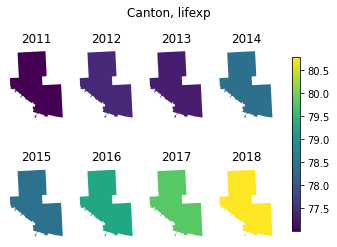

In [ ]:
plot_neighborhood_static(vsg, "Canton", "lifexp", figsize = (6,4))

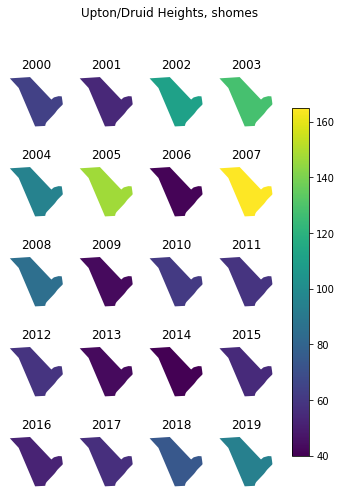

In [ ]:
plot_neighborhood_static(vsg, "Upton/Druid Heights", "shomes", figsize = (6, 8))

##### Updated version: takes an already-subsetted dataframe, more formatting options, more error handling

In [95]:
#### function to plot a single neighborhood for a single indicator over time (static plots)
# updated to use the subet_dataframe function 
### EVEN MORE ERROR HANDLING 

def plot_neighborhood_static(dat, figsize = (4,5), title_font_size = 14, cmap = None, 
                             legend_orientation = "vertical",
                             manual_title_adjustment = 0.0):
  '''
  Returns a figure with several subplots, showing how an indicator has changed in a given neighborhood over time 
  ***
  dat: a geodataframe, subsetted to the desired neighborhood, indicator, and year(s)
    (theoretically this function works with multiple neighborhoods, but title assumes it's only 1) 
  figsize: size of overall figure 
  title_font_size: how large the font should be (fontsize)
  cmap: color map for choropleth (set to default of None)
  legend_orientation: 'vertical' or 'horizontal'
  manual_title_adjustment: a float, representing how much to adjust the title. Can be negative or positive. 
  '''

  # get a list of years available, and make sure it's sorted
  yrs = [y for y in set(dat.year)]
  yrs.sort()
  # get the name of the csa(s), the indicator, and the indicator_description
  csa_s = [csa for csa in set(dat.CSA)]
  indicator = dat.indicator.iloc[0]
  ind_desc = dat.indicator_description.iloc[0]
  # figure out the dimensions of the figure subplots based on the number of years available
  rows, cols = subplot_dims(len(yrs))

  # set up the figure 
  fig, ax = plt.subplots(rows, cols, sharex = True, sharey = True, figsize = figsize)
  csa_title = ", \n".join(csa_s)
  figure_title = csa_title + "\n" + ind_desc
  # how much we offset the title depends on how many lines the title takes up, plus any manual adjustments
  title_position = 1 + (0.025 * csa_title.count("\n")) + manual_title_adjustment 
  fig.suptitle(figure_title, fontsize = title_font_size, y = title_position)
  # set up min and max values to anchor the choropleth, so legend is consistent
  anchor_min = dat.value.min()
  anchor_max = dat.value.max()

  # loop to create plot 
  # set starting year index (which year to grab from the list of years)
  yr_i = 0
  # go row by row 
  for r in range(0, rows): # r is the row index (0 base)
    # column by column
    for c in range(0, cols):
      # leave blank if we ran out of data
      if yr_i >= len(yrs):
        ax[r, c].axis('off')
      else:
        # get data 
        mapdat = dat[dat.year == yrs[yr_i]]
        # plot (with some error handling, if there's only 1 row)
        if rows == 1:
          mapdat.plot("value", ax = ax[c], vmin = anchor_min, vmax = anchor_max, cmap = cmap)
          ax[c].set_axis_off()
          ax[c].set_title(yrs[yr_i]) # title is year 
        else: 
          mapdat.plot("value", ax = ax[r,c], vmin = anchor_min, vmax = anchor_max, cmap = cmap)
          ax[r,c].set_axis_off()
          ax[r,c].set_title(yrs[yr_i]) # title is year 
        # move to the next year (by increasing the year index by 1)
        yr_i += 1
      

  ## overall figure aesthetics 
  # set legend
  if rows == 1: 
    patch_col = ax[0].collections[0]
  else: 
    patch_col = ax[0,0].collections[0]
  fig.colorbar(patch_col, ax = ax, shrink = 0.8, orientation = legend_orientation)

  return fig.show()

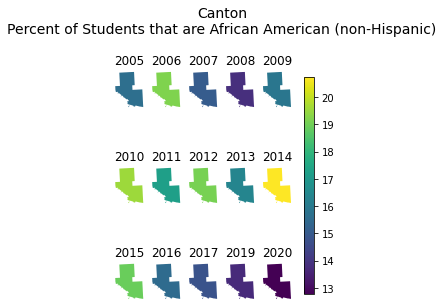

In [92]:
# test: Canton, aastud
ex1 = subset_dataframe(vsg, ["CSA", "indicator"], ["Canton","aastud"])
plot_neighborhood_static(ex1)

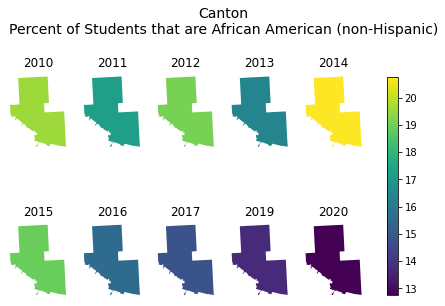

In [93]:
# same data, but subset to 2010 onwards, and change the figure size 
ex2 = subset_dataframe(vsg, ["CSA", "indicator","year_numeric"], ["Canton","aastud",2010],
                       condition_parameters = ["==","==",">="])
plot_neighborhood_static(ex2, figsize = (8, 5))

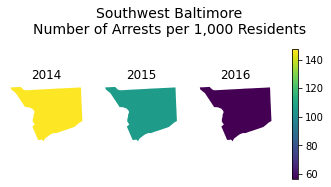

In [94]:
# testing with an indicator with only a few years of data 
ex3 = subset_dataframe(vsg, ["CSA","indicator"], ["Southwest Baltimore", "arrest"])
plot_neighborhood_static(ex3, figsize = (6,3))

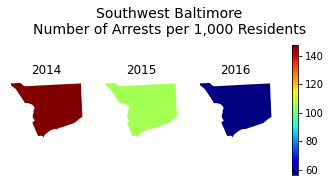

In [75]:
# same plot, but change the color scale 
plot_neighborhood_static(ex3, figsize = (6,3), cmap = "jet")

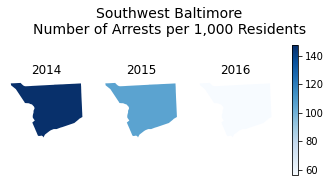

In [76]:
# change color again 
plot_neighborhood_static(ex3, figsize = (6,3), cmap = "Blues")

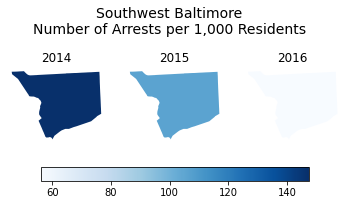

In [77]:
# change legend orientation 
plot_neighborhood_static(ex3, figsize = (6,3), cmap = "Blues",
                         legend_orientation = "horizontal")

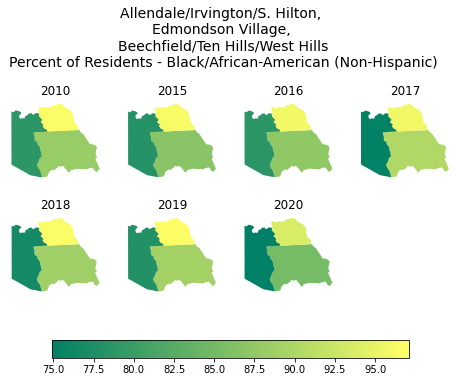

In [97]:
# will this work on multiple neighborhoods? 
csas = ['Beechfield/Ten Hills/West Hills','Allendale/Irvington/S. Hilton','Edmondson Village'] # according to BNIA map, these are next to each other 
ex4 = subset_dataframe(vsg, ["CSA", "indicator","year_numeric"], [csas,"paa",2010],["==","==",">="])
plot_neighborhood_static(ex4, figsize = (8,5.5), legend_orientation = "horizontal", cmap = "summer", manual_title_adjustment= 0.03)
# just need to change the title (fixed)

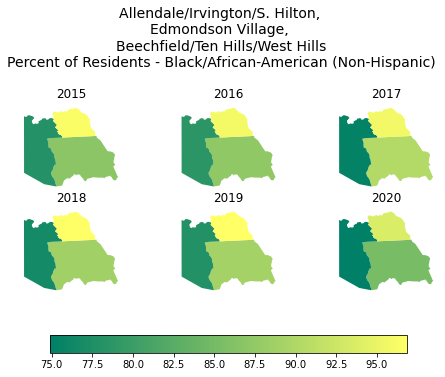

In [122]:
# same graph, but cut off 2010
ex5 = subset_dataframe(vsg, ["CSA", "indicator","year_numeric"], [csas,"paa",2015],["==","==",">="])
plot_neighborhood_static(ex5, figsize = (8,5), legend_orientation = "horizontal", cmap = "summer", manual_title_adjustment= 0.1)

### Function 4: Line plot comparing specific neighborhoods over time 

##### quick test

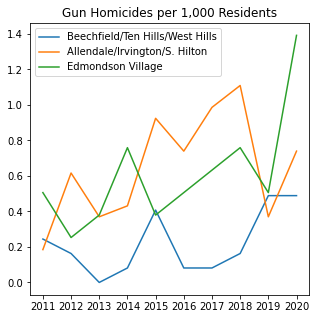

In [ ]:
#### testing out a single plot like this 

# let's look at household income for a few different neighborhoods 
csas = ['Beechfield/Ten Hills/West Hills','Allendale/Irvington/S. Hilton','Edmondson Village'] # according to BNIA map, these are next to each other 
linpltdat = subset_dataframe(vsg, columns = ["CSA","indicator"], subset_vals = [csas,"gunhom"])
linpltdat.head()

### plot 
for csa in csas:
  lindat = linpltdat[linpltdat.CSA == csa] 
  plt.plot(lindat.year_numeric, lindat.value, label = csa)
plt.legend()
plt.title("Gun Homicides per 1,000 Residents")
xticks = list(set(linpltdat.year_numeric))
plt.xticks(xticks)
plt.show()


##### function + testing

In [98]:
### make it a function 
def selected_line_plot(csas, indicator, color_list = None, figsize = (5,5),
                       legend_loc = "best", 
                       year_before = 2050,
                       year_after = 1900):
  # get data 
  linpltdat = subset_dataframe(vsg, columns = ["CSA","indicator"], subset_vals = [csas,indicator])
  linpltdat = linpltdat[linpltdat.year_numeric.notna()]
  linpltdat = linpltdat[(linpltdat.year_numeric >= year_after) & (linpltdat.year_numeric <= year_before)]
  # grab indicator description 
  ind_desc = linpltdat.indicator_description.iloc[0]
  # plot (no specified colors)
  if color_list == None:
    for csa in csas:
      lindat = linpltdat[linpltdat.CSA == csa] 
      plt.plot(lindat.year_numeric, lindat.value, label = csa)
  # plot (specified colors [must be same length as number of CSAs])
  else: 
    for i in range(0, len(csas)):
      lindat = linpltdat[linpltdat.CSA == csas[i]]
      plt.plot(lindat.year_numeric, lindat.value, label = csas[i], color = color_list[i])

  # aesthetics 
  plt.legend(loc = legend_loc)
  plt.title(ind_desc)
  xticks = list(set(linpltdat.year_numeric))
  plt.xticks(xticks)
  plt.rcParams["figure.figsize"] = figsize
  plt.show()



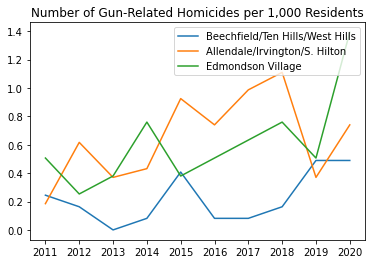

In [99]:
# test 
csas = ['Beechfield/Ten Hills/West Hills','Allendale/Irvington/S. Hilton','Edmondson Village'] # according to BNIA map, these are next to each other 
selected_line_plot(csas, "gunhom", legend_loc = "upper right")

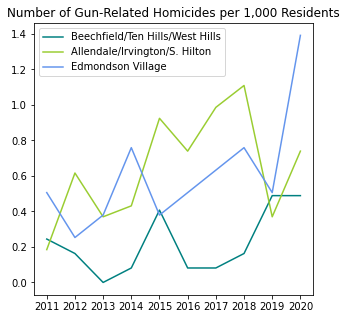

In [ ]:
# test, change colors 
selected_line_plot(csas, "gunhom", color_list = ["teal","yellowgreen","cornflowerblue"])

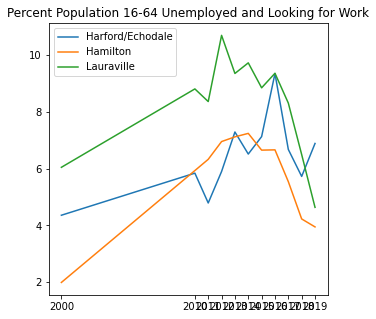

In [100]:
# test, change CSAs and indicator 
selected_line_plot(['Harford/Echodale','Hamilton','Lauraville'],"unempl") # something strange
# this looks messed up because we're missing data between 2000 and 2010

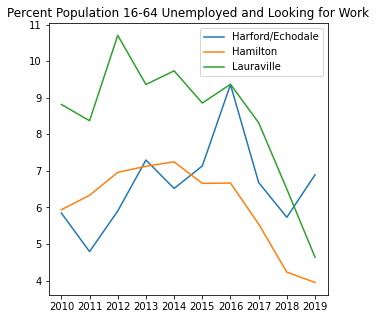

In [101]:
# fixed issue of missing data by giving more flexibility to filter by year 
selected_line_plot(['Harford/Echodale','Hamilton','Lauraville'],"unempl", year_after = 2010)

### Function 5: Line plot comparing one neighborhood to all others over time 

In [108]:
#### same line plot idea, but now compare 1 highlighted csa to all others 

def highlight_line_plot(indicator,csa_of_interest, year_before = 2050, year_after = 1990,
                        figsize = (5,5), highlight_color = "orange",
                        legend_loc = "best", 
                        alpha = 0.25):
  '''
  Function to create a line plot with one highlighted line of interest 
  ***
  indicator: the shortname of the indicator of interest
  csa_of_interest: the CSA to be highlighted 
  year_before: filter to all years less than or equal to this year  (2050 as a placeholder)
  year_after: filter to all years greater than or equal to this year (1990 as a placeholder)
  figsize: dimensions of the figure 
  highlight_color: color of the line of interest 
  legened_loc: location of the legend 
  alpha: transparency level of the grey lines (default is 0.25)
  '''
  linpltdat = subset_dataframe(vsg, columns = ["indicator"], subset_vals = [indicator])
  # filter out NA values, filter to desired time frame 
  linpltdat = linpltdat[linpltdat.year_numeric.notna()]
  linpltdat = linpltdat[(linpltdat.year_numeric >= year_after) & (linpltdat.year_numeric <= year_before)]
  # grab indicator description 
  ind_desc = linpltdat.indicator_description.iloc[0]

  # plot line of interest
  csadat = linpltdat[linpltdat.CSA == csa_of_interest]
  plt.plot(csadat.year_numeric, csadat.value, label = csa_of_interest, color = highlight_color,
           linewidth = 2)

  ## plot all other lines
  # get list of all other CSAs
  other_csas = set(linpltdat.CSA)
  other_csas.remove(csa_of_interest)
  # loop through other csas
  for csa in other_csas: 
    lindat = linpltdat[linpltdat.CSA == csa] 
    plt.plot(lindat.year_numeric, lindat.value, label = None, 
             color = "grey", alpha = alpha, linewidth = 1) # grey out aesthetics

  # aesthetics 
  plt.legend(loc = legend_loc)
  title_text = ind_desc + "\n" + csa_of_interest + " vs. other CSAs"
  plt.title(title_text)
  xticks = list(set(linpltdat.year_numeric))
  plt.xticks(xticks)
  plt.rcParams["figure.figsize"] = figsize
  plt.show()
  

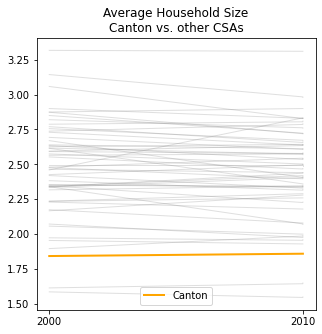

In [109]:
# simple example (only 2 years of data for this indicator)
highlight_line_plot("hhsize", "Canton")

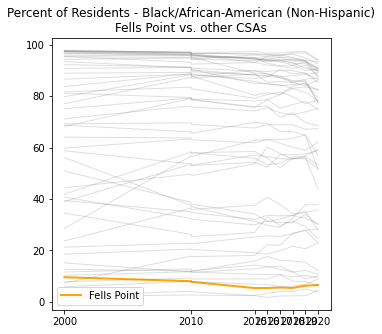

In [110]:
# another issue of missing years 
highlight_line_plot("paa","Fells Point")

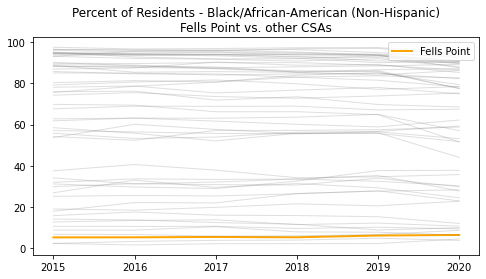

In [113]:
highlight_line_plot("paa","Fells Point", year_after = 2015,
                    figsize = (8, 4), legend_loc = "upper right")

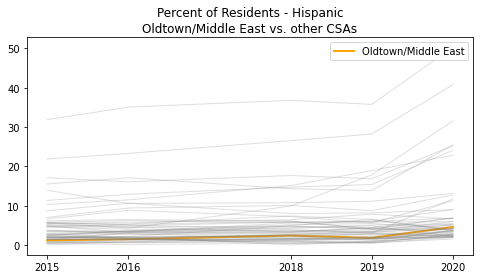

In [112]:
highlight_line_plot("phisp","Oldtown/Middle East",year_after = 2015,
                    figsize = (8, 4), legend_loc = "upper right")

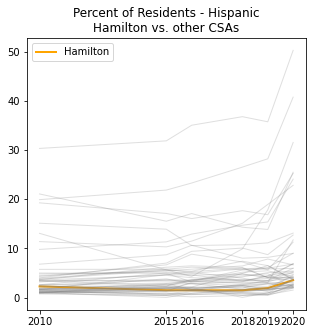

In [116]:
highlight_line_plot("phisp","Hamilton", year_after = 2010)

### Animate over time (abandoned for now, taking too long for not great results)

In [ ]:
# sample data (one indicator, one neighborhood)
x = vsg[(vsg.indicator == "aastud") & (vsg.CSA == "Canton")].copy()
# remove NA values 
x.dropna(subset = ["value"], inplace = True)
x.shape # there are 15 years of data 
x

In [ ]:
### attempt 1 

# loop over years 
yr_list = [y for y in x.year]
# set min and max for legend
vmin = x.value.min()
vmax = x.value.max()
# loop
for yr in yr_list: 
  mapdata = x[x.year == yr]
  fig = mapdata.plot("value", legend = True,
                     norm=plt.Normalize(vmin=vmin, vmax=vmax))
  ax.cla()
# this displays simple graphs 

In [ ]:
g = mapdata.plot("value", legend = True,
                     norm=plt.Normalize(vmin=vmin, vmax=vmax))

In [ ]:
# attempt 2 (based on https://stackoverflow.com/questions/65533180/how-do-i-fill-an-animated-shape-with-matplotlib)
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()

# init function 
def init():
  ax.axis('placeholder')
  return x.plot("value")

# animation function 
def update(frame):
  mapdata = x[x.year == yr]
  return mapdata.plot("value")

ani = FuncAnimation(fig, update, frames = yr_list, init_func = init)
plt.show()

In [ ]:
# attempt 3 - saving a gif 
# combo of:
  # https://towardsdatascience.com/how-to-make-a-gif-map-using-python-geopandas-and-matplotlib-cd8827cefbc8
  # https://stackoverflow.com/questions/753190/programmatically-generate-video-or-animated-gif-in-python

# folder of gifs 
yr_list = [y for y in x.year]
# set min and max for legend
vmin = x.value.min()
vmax = x.value.max()
# loop
for yr in yr_list: 
  mapdata = x[x.year == yr]
  fig = mapdata.plot("value", legend = True,
                     norm=plt.Normalize(vmin=vmin, vmax=vmax))
  fig.axis('off')
  fig.set_title("Test - Animation of Baltimore Neighborhood")
  filepath = "gif_test/test1_" + str(yr) + '.jpg'
  chart = fig.get_figure()
  chart.savefig(filepath, dpi = 300)

In [ ]:
# attempt 3 continued, merge into a gif
import imageio

filenames = os.listdir("gif_test")
filenames.sort()
full_filenames = ['gif_test/' + f for f in filenames]


images = []
for filename in full_filenames: 
  images.append(imageio.imread(filename))
imageio.mimsave('test_gif_output.gif', images)
# this worked! the gif is silly right now, but it worked 

In [ ]:
# attempt 4 (kinda going back to attempt 1)
vmin = x.value.min()
vmax = x.value.max()
neighborhood = x.CSA.iloc[0]
indicator = x.indicator.iloc[0]
# yr = "2005"

fig, ax = plt.subplots()
#fig.set_dpi(100)

title_txt = neighborhood + ", " + indicator + " (" + yr + ")"
plt.title(title_txt)

def init():
  yr = yr_list[0]
  ax = x[x.year == yr].plot("value", legend = True,
                               norm=plt.Normalize(vmin=vmin, vmax=vmax))
  ax.axis('off')
  return ax

def animate(i):
  yr = yr_list[i]
  ax = x[x.year == yr].plot("value", legend = True,
                               norm=plt.Normalize(vmin=vmin, vmax=vmax),
                            axis = ax)
  return ax 

anim = FuncAnimation(fig, animate, 
                     init_func = init, 
                     frames = range(0, len(yr_list)))



In [ ]:
# install and load plotly 
!pip install plotly
import plotly.express as px

In [ ]:
# the plotly functions we want reply on mapbox, which requires a mapbox token (free)
# sign up to get a token here: https://docs.mapbox.com/accounts/guides/tokens/#default-public-access-token
px.set_mapbox_access_token("pk.eyJ1IjoiZWpmNzgiLCJhIjoiY2t5eXBwaGdqMHVqdzJ2bzI2ajR1ZWZvaCJ9.NRT799fGBw6Bhf8M-AgEGg")

In [ ]:
vsg

In [ ]:
### trying out a plot from the following: https://towardsdatascience.com/simple-plotly-tutorials-868bd0890b8b
## isolating the data to use (single CSA and indicator)
x = vsg[(vsg.indicator == "aastud") & (vsg.CSA == "Canton")]
x.shape 

# set up plotly/geopandas figure 
fig = px.choropleth_mapbox(x, 
                           geojson = x.geometry,
                           locations = 'CSA',
                           color = 'value', 
                           animation_frame = 'year_numeric')
fig.show()


In [ ]:
# things are wonky, I think because of the format of the geometry 
# from this answer: https://stackoverflow.com/questions/65507374/plotting-a-geopandas-dataframe-using-plotly

import pyproj
x2 = x.copy()
x2.to_crs(pyproj.CRS.from_epsg(4326), inplace = True)

In [ ]:
fig = px.choropleth_mapbox(x2, 
                           geojson = x2.CSA,
                           locations = 'CSA',
                           color = 'value', 
                           animation_frame = 'year_numeric')
fig.show()

In [ ]:
# the issue is that the geometry is not in the required format 
# convert geopandas shapely polygon to geojson: https://stackoverflow.com/questions/51486454/convert-geopandas-shapely-polygon-to-geojson
# gjson = gpd.GeoSeries([vsg.geometry]).to_json() #nope, this will run through all availbale ram 

In [ ]:

shapely.geometry.mapping(vsg.geometry)